In [1]:
%pip install -q python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import configparser
from tqdm.auto import tqdm
from functools import reduce
from dotenv import load_dotenv
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, length, max
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import FloatType

In [3]:
load_dotenv()

True

In [ ]:
IP_ADDRESS = os.environ["CLICKHOUSE_IP_ADDRESS"]
PORT = os.environ["CLICKHOUSE_PORT"]
USER = os.environ["CLICKHOUSE_USER"]
PASSWORD = os.environ["CLICKHOUSE_PASSWORD"]
DATABASE = os.environ["CLICKHOUSE_DATABASE"]
PROTOCOL = os.environ["CLICKHOUSE_PROTOCOL"]
TABLE = "openfoodfacts"
spark_config_apth = 'conf/spark.ini'
IP_ADDRESS, PORT

('clickhouse', '8123')

In [7]:
config = configparser.ConfigParser()
config.optionxform=str
config.read(spark_config_apth)
list(config['spark'].items())

[('spark.master', 'local[*]'),
 ('spark.driver.memory', '1g'),
 ('spark.executor.memory', '1g'),
 ('spark.executor.instances', '4'),
 ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
 ('spark.dynamicAllocation.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.dynamicAllocation.maxExecutors', '6')]

In [8]:
conf = SparkConf()
conf.setAll(list(config['spark'].items()))

In [ ]:
spark = SparkSession.builder.config(conf=conf) \
    .config("spark.sql.catalog.clickhouse.host", IP_ADDRESS) \
    .config("spark.sql.catalog.clickhouse.protocol", PROTOCOL) \
    .config("spark.sql.catalog.clickhouse.http_port", PORT) \
    .config("spark.sql.catalog.clickhouse.user", USER) \
    .config("spark.sql.catalog.clickhouse.password", PASSWORD) \
    .config("spark.sql.catalog.clickhouse.database", DATABASE) \
    .getOrCreate()
    
sc = spark.sparkContext

In [54]:
spark.stop()

In [11]:
useful_cols = [
    'code',
    # 'energy_kcal_100g',
    'fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'proteins_100g',
    'salt_100g',
    'sodium_100g',
]

In [12]:
url = f"jdbc:clickhouse://{IP_ADDRESS}:{PORT}/{DATABASE}?socket_timeout=300000"
driver = "com.clickhouse.jdbc.ClickHouseDriver"
query = f"""
(SELECT 
    *,
    rowNumberInBlock() AS numeric_index 
FROM {TABLE}) AS subquery
"""

In [15]:
df = spark.read.format('jdbc') \
        .option('driver', driver) \
        .option('url', url) \
        .option('dbtable', query) \
        .option('user', USER) \
        .option('password', PASSWORD) \
        .option("partitionColumn", "numeric_index") \
        .option("lowerBound", "1") \
        .option("upperBound", "100") \
        .option("numPartitions", "11") \
        .load()
  
df.cache().show(5, False)     

+------------+----------------------------------------------------------------------------------------------------------+-------+----------+--------------------+---------------+----------------------+----------------+--------------+---------------------+----------------------------------------+------------------------+------------+------------------+---------+--------------+------------+--------------+--------------+-----------------+--------------+-------------------------------------------+----------------------------------------------------+----------------------------------------------+-------+------------+----------+--------------------+-------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
df.count()

180215

In [17]:
df.rdd.getNumPartitions()

11

In [34]:
df.unpersist()

DataFrame[code: string, url: string, creator: string, created_t: string, created_datetime: string, last_modified_t: string, last_modified_datetime: string, last_modified_by: string, last_updated_t: string, last_updated_datetime: string, product_name: string, abbreviated_product_name: string, generic_name: string, quantity: string, packaging: string, packaging_tags: string, packaging_en: string, packaging_text: string, brands: string, brands_tags: string, brands_en: string, categories: string, categories_tags: string, categories_en: string, origins: string, origins_tags: string, origins_en: string, manufacturing_places: string, manufacturing_places_tags: string, labels: string, labels_tags: string, labels_en: string, emb_codes: string, emb_codes_tags: string, first_packaging_code_geo: string, cities: string, cities_tags: string, purchase_places: string, stores: string, countries: string, countries_tags: string, countries_en: string, ingredients_text: string, ingredients_tags: string, in

In [18]:
processed_df = df.select(*useful_cols).na.drop()
processed_df.show() 

+-------------+---------------+------------------+-----------+---------------+---------------+----------------+
|         code|       fat_100g|carbohydrates_100g|sugars_100g|  proteins_100g|      salt_100g|     sodium_100g|
+-------------+---------------+------------------+-----------+---------------+---------------+----------------+
| 000000000063|             25|                 3|          1|             23|            1.2|            0.48|
| 000000000114|             44|                30|         27|            7.1|          0.025|            0.01|
|     00000002|            5.6|               7.5|        6.2|            2.3|            0.4|            0.16|
|     00000004|              0|                26|         15|              1|              0|               0|
|   0000000475|              0|              50.8|       50.6|            0.8|              0|               0|
|     00000005|            1.6|               6.7|        1.3|             82|            1.7|          

In [19]:
processed_df.count()

130749

In [20]:
len(processed_df.columns)

7

In [21]:
metadata_cols = ['code']
feature_cols = [c for c in useful_cols if c not in metadata_cols]
feature_cols

['fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

In [ ]:
for column in feature_cols:
    processed_df = processed_df.withColumn(column, col(column).cast(FloatType()))

processed_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- fat_100g: float (nullable = true)
 |-- carbohydrates_100g: float (nullable = true)
 |-- sugars_100g: float (nullable = true)
 |-- proteins_100g: float (nullable = true)
 |-- salt_100g: float (nullable = true)
 |-- sodium_100g: float (nullable = true)



In [23]:
cluster_count = int(config['model']['k'])
seed = int(config['model']['seed'])

kmeans = KMeans(k=cluster_count).setSeed(seed)

In [45]:
cluster_df = VectorAssembler(
    inputCols=feature_cols, 
    outputCol="features").transform(processed_df)
cluster_df.show()

+-------------+---------+------------------+-----------+-------------+----------+-----------+--------------------+
|         code| fat_100g|carbohydrates_100g|sugars_100g|proteins_100g| salt_100g|sodium_100g|            features|
+-------------+---------+------------------+-----------+-------------+----------+-----------+--------------------+
|0041220502950| 71.42857|         14.285714|  3.5714285|    10.714286|       0.0|        0.0|[71.4285736083984...|
|0041220504367|      0.0|             100.0|   96.15385|          0.0|0.28846154|0.115384616|[0.0,100.0,96.153...|
|0041220505470|2.0408163|         4.4897957| 0.40816328|    5.3061223| 0.8877551| 0.35510203|[2.04081630706787...|
|0041220505593|      0.0|          4.424779| 0.88495576|    1.7699115| 0.5973451| 0.23893805|[0.0,4.4247789382...|
|0041220505616|      0.0|          4.424779| 0.88495576|    1.7699115| 0.5973451| 0.23893805|[0.0,4.4247789382...|
|0041220505623|25.294117|               0.0|        0.0|    15.882353|0.16176471

In [21]:
model = kmeans.fit(cluster_df)

In [22]:
model.hasSummary

True

In [23]:
model.summary.k

5

In [24]:
model.summary.clusterSizes

[453988, 1, 2, 141, 2258]

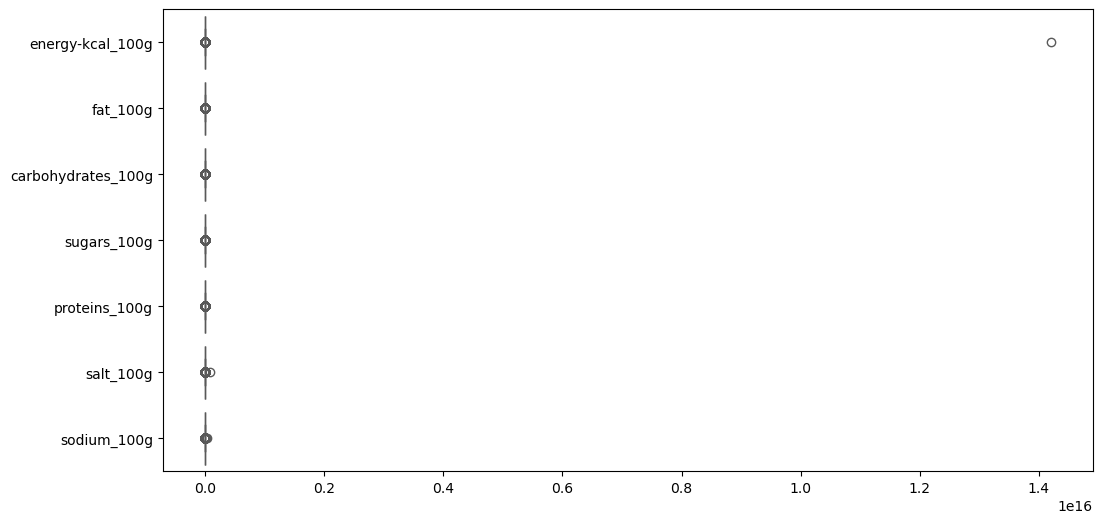

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=processed_df.drop(*metadata_cols).toPandas(), orient='h', palette="Set2")
plt.show()

In [53]:
# an energy-amount of more than 1000kcal 
# (the maximum amount of energy a product can have; 
# in this case it would conists of 100% fat)
processed_df = processed_df.filter(col('energy_kcal_100g') < 1000)
processed_df.show()

+----+--------+------------------+-----------+-------------+---------+-----------+
|code|fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|
+----+--------+------------------+-----------+-------------+---------+-----------+
+----+--------+------------------+-----------+-------------+---------+-----------+



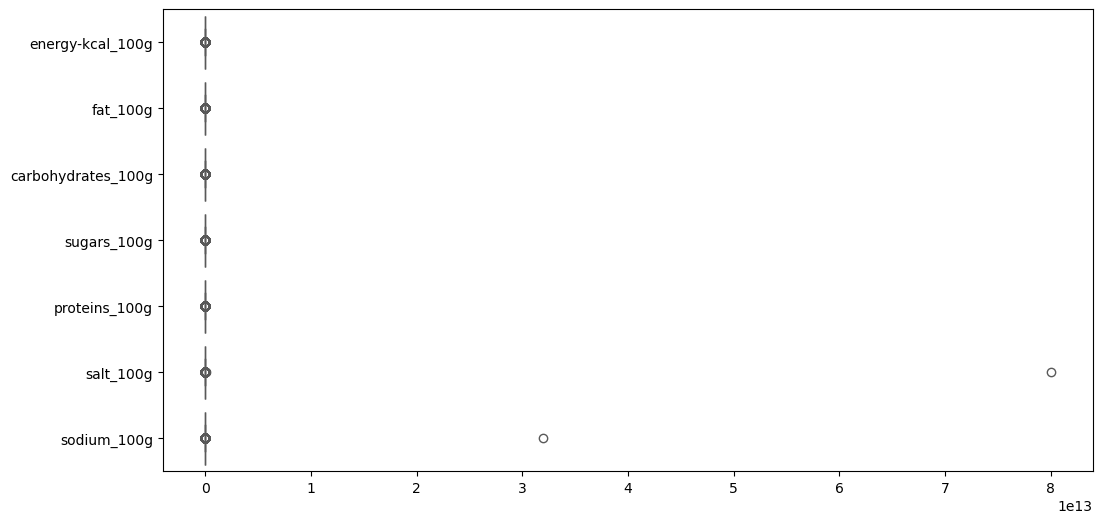

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=processed_df.drop(*metadata_cols).toPandas(), 
    orient='h', 
    palette="Set2")
plt.show()

In [24]:
# a feature (except for the energy-ones) higher than 100g
columns_to_filter = [c for c in processed_df.columns if c != 'energy_kcal_100g' and c not in metadata_cols]
print(columns_to_filter)

condition = reduce(
    lambda a, b: a & (col(b) < 100),
    columns_to_filter,
    col(columns_to_filter[0]) < 100 
)

# a feature (except for the energy-ones) higher than 100g
processed_df = processed_df.filter(condition)
processed_df.show()

['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']
+-------------+---------+------------------+-----------+-------------+---------+-----------+
|         code| fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|
+-------------+---------+------------------+-----------+-------------+---------+-----------+
| 000000000063|     25.0|               3.0|        1.0|         23.0|      1.2|       0.48|
| 000000000114|     44.0|              30.0|       27.0|          7.1|    0.025|       0.01|
|     00000002|      5.6|               7.5|        6.2|          2.3|      0.4|       0.16|
|     00000004|      0.0|              26.0|       15.0|          1.0|      0.0|        0.0|
|   0000000475|      0.0|              50.8|       50.6|          0.8|      0.0|        0.0|
|     00000005|      1.6|               6.7|        1.3|         82.0|      1.7|       0.68|
|0000209534006|      4.3|               6.3|        4.2|          2.

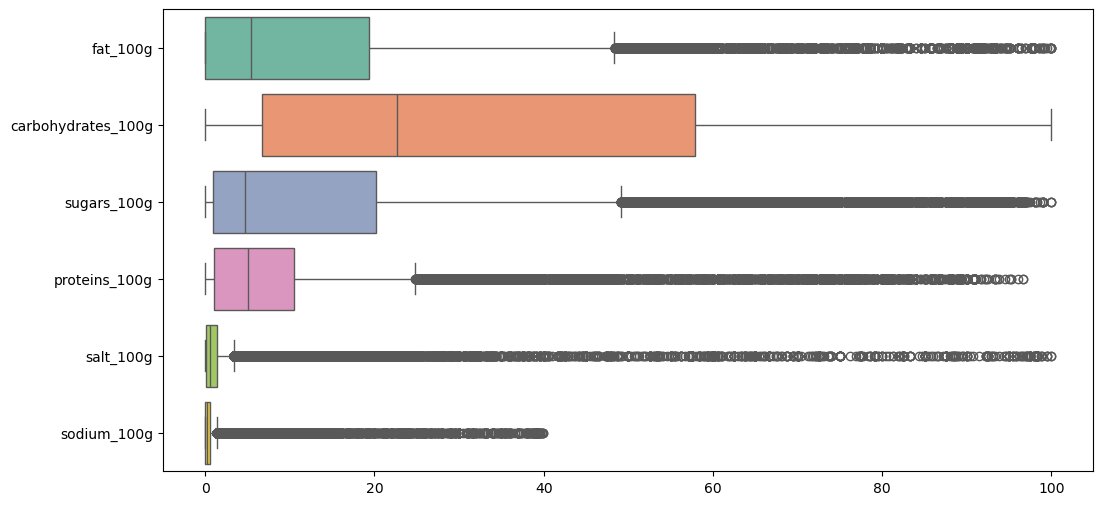

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=processed_df.drop(*metadata_cols).toPandas(), orient='h', palette="Set2")
plt.show()

In [25]:
# a feature with a negative entry
condition = reduce(
    lambda a, b: a & (col(b) >= 0),
    feature_cols,
    col(feature_cols[0]) >= 0 
)
processed_df = processed_df.filter(condition)
processed_df.show()

+-------------+---------+------------------+-----------+-------------+---------+-----------+
|         code| fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|
+-------------+---------+------------------+-----------+-------------+---------+-----------+
| 000000000063|     25.0|               3.0|        1.0|         23.0|      1.2|       0.48|
| 000000000114|     44.0|              30.0|       27.0|          7.1|    0.025|       0.01|
|     00000002|      5.6|               7.5|        6.2|          2.3|      0.4|       0.16|
|     00000004|      0.0|              26.0|       15.0|          1.0|      0.0|        0.0|
|   0000000475|      0.0|              50.8|       50.6|          0.8|      0.0|        0.0|
|     00000005|      1.6|               6.7|        1.3|         82.0|      1.7|       0.68|
|0000209534006|      4.3|               6.3|        4.2|          2.9|     0.11|      0.044|
|0000209773750|      7.8|              44.8|        1.2|          7.6|

In [26]:
cluster_df = VectorAssembler(
    inputCols=feature_cols, 
    outputCol="features").transform(processed_df)
cluster_df.show()

+-------------+---------+------------------+-----------+-------------+---------+-----------+--------------------+
|         code| fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|            features|
+-------------+---------+------------------+-----------+-------------+---------+-----------+--------------------+
| 000000000063|     25.0|               3.0|        1.0|         23.0|      1.2|       0.48|[25.0,3.0,1.0,23....|
| 000000000114|     44.0|              30.0|       27.0|          7.1|    0.025|       0.01|[44.0,30.0,27.0,7...|
|     00000002|      5.6|               7.5|        6.2|          2.3|      0.4|       0.16|[5.59999990463256...|
|     00000004|      0.0|              26.0|       15.0|          1.0|      0.0|        0.0|[0.0,26.0,15.0,1....|
|   0000000475|      0.0|              50.8|       50.6|          0.8|      0.0|        0.0|[0.0,50.799999237...|
|     00000005|      1.6|               6.7|        1.3|         82.0|      1.7|       0

In [27]:
model = kmeans.fit(cluster_df)

In [28]:
model.summary.clusterSizes

[55928, 10700, 16783, 22305, 14231]

In [29]:
transformed = model.transform(cluster_df)
transformed.show()

+-------------+---------+------------------+-----------+-------------+---------+-----------+--------------------+----------+
|         code| fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|            features|prediction|
+-------------+---------+------------------+-----------+-------------+---------+-----------+--------------------+----------+
| 000000000063|     25.0|               3.0|        1.0|         23.0|      1.2|       0.48|[25.0,3.0,1.0,23....|         4|
| 000000000114|     44.0|              30.0|       27.0|          7.1|    0.025|       0.01|[44.0,30.0,27.0,7...|         4|
|     00000002|      5.6|               7.5|        6.2|          2.3|      0.4|       0.16|[5.59999990463256...|         0|
|     00000004|      0.0|              26.0|       15.0|          1.0|      0.0|        0.0|[0.0,26.0,15.0,1....|         0|
|   0000000475|      0.0|              50.8|       50.6|          0.8|      0.0|        0.0|[0.0,50.799999237...|         2|


# silhouette_score
 
- The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [76]:
evaluator = ClusteringEvaluator()
evaluator.evaluate(transformed.select('features', 'prediction'))

0.5959226720453848

In [71]:
model_path = "/sparkdata/kmeans_model"
model.save(model_path)

# Write result to database

In [34]:
df.drop('numeric_index', 'prediction') \
    .join(transformed.select(*metadata_cols, 'prediction'), on='code', how='left') \
    .show(5, False)

+------------+----------------------------------------------------------------------------------------------------------+-------+----------+--------------------+---------------+----------------------+----------------+--------------+---------------------+----------------------------------------+------------------------+------------+------------------+---------+--------------+------------+--------------+--------------+-----------------+--------------+-------------------------------------------+----------------------------------------------------+----------------------------------------------+-------+------------+----------+--------------------+-------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------

In [36]:
spark.sql(f'TRUNCATE TABLE clickhouse.default.{TABLE}')

DataFrame[]

In [37]:
df.drop('numeric_index', 'prediction') \
    .join(transformed.select(*metadata_cols, 'prediction'), on='code', how='left') \
    .write.mode("append") \
    .format("jdbc") \
    .option("driver", driver) \
    .option("url", url) \
    .option("dbtable", TABLE) \
    .option("user", USER) \
    .option("password", PASSWORD) \
    .save()

# Stop spark session

In [ ]:
spark.stop()